In [78]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from imblearn.metrics import specificity_score

import os

#### Information on data:
- Booking data for 2 hotels 
- Both hotels are located in Portugal: H1 at the resort region of Algarve and H2 at the city of Lisbon
- Source: https://www.sciencedirect.com/science/article/pii/S2352340918315191

#### Model: 
- Bookings cancellation prediction: development of prediction models to classify a hotel booking׳s likelihood to be canceled. 
- Or do a cancelation ratio per day & probability of it to occur (??)

### Read clean data from csv

In [2]:
data = pd.read_csv('../data/Hotels.csv')

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
data.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,Hotel,Arrival_Date_MonthN,ArrivalDateFull,TotalNights
0,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,Not applicable,Not applicable,0,Transient,75.0,0,0,Check-Out,2015-07-02,H1,7,2015-07-01,1
1,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304,Not applicable,0,Transient,75.0,0,0,Check-Out,2015-07-02,H1,7,2015-07-01,1
2,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,Not applicable,0,Transient,98.0,0,1,Check-Out,2015-07-03,H1,7,2015-07-01,2
3,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,Not applicable,0,Transient,98.0,0,1,Check-Out,2015-07-03,H1,7,2015-07-01,2
4,0,0,2015,July,27,1,0,2,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,Not applicable,Not applicable,0,Transient,107.0,0,0,Check-Out,2015-07-03,H1,7,2015-07-01,2


In [5]:
data = data[data.Hotel=='H1']
data.Hotel.value_counts()

H1    39665
Name: Hotel, dtype: int64

In [97]:
data.DepositType.value_counts()

No Deposit         37804
Non Refund          1719
Refundable           142
Name: DepositType, dtype: int64

In [99]:
data[data.IsCanceled==1].DepositType.value_counts()

No Deposit         9438
Non Refund         1650
Refundable           22
Name: DepositType, dtype: int64

### Feature engineering

In [6]:
data_drop = data.sample(10000)

Drop irrelevant columns

In [7]:
data_drop.drop(['TotalNights', 'ArrivalDateFull', 'Arrival_Date_MonthN', 'ReservationStatusDate', 
                'TotalOfSpecialRequests', 'AssignedRoomType', 'Meal', 'ReservationStatus', 
                'Hotel', 'Country', 'RequiredCarParkingSpaces'], axis=1, inplace=True)

In [8]:
print(data_drop.shape)
data_drop.head()

(10000, 24)


,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR
16520,0,37,2015,September,36,2,0,2,3,0.0,0,Online TA,TA/TO,0,0,0,G,3,No Deposit,241,Not applicable,0,Transient,117.81
36811,0,1,2017,June,23,10,0,1,2,0.0,0,Direct,TA/TO,0,0,0,A,0,No Deposit,Not applicable,Not applicable,0,Group,135.00
38579,0,112,2017,July,31,30,2,3,2,0.0,0,Direct,Direct,0,0,0,F,0,No Deposit,250,Not applicable,0,Transient,246.00
35418,0,88,2017,April,17,29,2,1,2,0.0,0,Offline TA/TO,TA/TO,0,0,0,A,0,No Deposit,171,Not applicable,0,Transient,68.40
15310,0,30,2015,July,28,6,2,5,2,0.0,0,Online TA,TA/TO,0,0,0,E,0,No Deposit,240,Not applicable,0,Transient,155.00


#### Reduce Agent & Company to have only top agents

In [9]:
data_drop.Agent = [agent.strip() for agent in data_drop.Agent]

In [10]:
top = list(data_drop.Agent.value_counts().head(10).index)
top = [x for x in top if x != 'Not applicable']
top

['240', '250', '241', '40', '314', '242', '6', '243', '298']

In [11]:
for agent in data_drop.Agent:
    if agent == 'Not applicable':
        continue
    if agent not in top:
        data_drop.Agent = data_drop.Agent.replace(agent, 'Other')
    else:
        continue

In [12]:
data_drop.Agent.value_counts()

240               3483
Other             2275
Not applicable    2036
250                720
241                444
40                 230
314                229
242                179
6                  144
243                131
298                129
Name: Agent, dtype: int64

#### Company

In [13]:
top_comp = list(data_drop.Company.value_counts().head(10).index)
top_comp = [x for x in top_comp if x != 'Not applicable']
top_comp

['       Not applicable',
 '        223',
 '        281',
 '        405',
 '        154',
 '         94',
 '        135',
 '        331',
 '        110',
 '        204']

In [14]:
for company in data_drop.Company:
    if company == 'Not applicable':
        continue
    if company not in top_comp:
         data_drop.Company = data_drop.Company.replace(company, 'Other')
    else:
        continue

In [15]:
data_drop.Company.value_counts()

       Not applicable    9213
Other                     403
        223               192
        281                39
        405                29
        154                28
         94                24
        135                21
        331                20
        110                17
        204                14
Name: Company, dtype: int64

In [16]:
print(data_drop.shape)
data_drop.head()

(10000, 24)


,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR
16520,0,37,2015,September,36,2,0,2,3,0.0,0,Online TA,TA/TO,0,0,0,G,3,No Deposit,241,Not applicable,0,Transient,117.81
36811,0,1,2017,June,23,10,0,1,2,0.0,0,Direct,TA/TO,0,0,0,A,0,No Deposit,Not applicable,Not applicable,0,Group,135.00
38579,0,112,2017,July,31,30,2,3,2,0.0,0,Direct,Direct,0,0,0,F,0,No Deposit,250,Not applicable,0,Transient,246.00
35418,0,88,2017,April,17,29,2,1,2,0.0,0,Offline TA/TO,TA/TO,0,0,0,A,0,No Deposit,Other,Not applicable,0,Transient,68.40
15310,0,30,2015,July,28,6,2,5,2,0.0,0,Online TA,TA/TO,0,0,0,E,0,No Deposit,240,Not applicable,0,Transient,155.00


### One Hot Encoding

In [17]:
data_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 16520 to 14131
Data columns (total 24 columns):
IsCanceled                     10000 non-null int64
LeadTime                       10000 non-null int64
ArrivalDateYear                10000 non-null int64
ArrivalDateMonth               10000 non-null object
ArrivalDateWeekNumber          10000 non-null int64
ArrivalDateDayOfMonth          10000 non-null int64
StaysInWeekendNights           10000 non-null int64
StaysInWeekNights              10000 non-null int64
Adults                         10000 non-null int64
Children                       10000 non-null float64
Babies                         10000 non-null int64
MarketSegment                  10000 non-null object
DistributionChannel            10000 non-null object
IsRepeatedGuest                10000 non-null int64
PreviousCancellations          10000 non-null int64
PreviousBookingsNotCanceled    10000 non-null int64
ReservedRoomType               10000 non-null obje

In [18]:
data_dummies = pd.get_dummies(data=data_drop, columns=['ArrivalDateMonth', 'MarketSegment', 'DistributionChannel',
                                                       'ReservedRoomType', 'DepositType', 'Agent', 'CustomerType',
                                                      'Company'])

In [19]:
print(data_dummies.shape)
data_dummies.head()

(10000, 73)


,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,BookingChanges,DaysInWaitingList,ADR,ArrivalDateMonth_April,ArrivalDateMonth_August,ArrivalDateMonth_December,ArrivalDateMonth_February,ArrivalDateMonth_January,ArrivalDateMonth_July,ArrivalDateMonth_June,ArrivalDateMonth_March,ArrivalDateMonth_May,ArrivalDateMonth_November,ArrivalDateMonth_October,ArrivalDateMonth_September,MarketSegment_Complementary,MarketSegment_Corporate,MarketSegment_Direct,MarketSegment_Groups,MarketSegment_Offline TA/TO,MarketSegment_Online TA,DistributionChannel_Corporate,DistributionChannel_Direct,DistributionChannel_TA/TO,ReservedRoomType_A,ReservedRoomType_C,ReservedRoomType_D,ReservedRoomType_E,ReservedRoomType_F,ReservedRoomType_G,ReservedRoomType_H,DepositType_No Deposit,DepositType_Non Refund,DepositType_Refundable,Agent_240,Agent_241,Agent_242,Agent_243,Agent_250,Agent_298,Agent_314,Agent_40,Agent_6,Agent_Not applicable,Agent_Other,CustomerType_Contract,CustomerType_Group,CustomerType_Transient,CustomerType_Transient-Party,Company_ 94,Company_ 110,Company_ 135,Company_ 154,Company_ 204,Company_ 223,Company_ 281,Company_ 331,Company_ 405,Company_ Not applicable,Company_Other
16520,0,37,2015,36,2,0,2,3,0.0,0,0,0,0,3,0,117.81,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
36811,0,1,2017,23,10,0,1,2,0.0,0,0,0,0,0,0,135.00,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
38579,0,112,2017,31,30,2,3,2,0.0,0,0,0,0,0,0,246.00,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
35418,0,88,2017,17,29,2,1,2,0.0,0,0,0,0,0,0,68.40,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
15310,0,30,2015,28,6,2,5,2,0.0,0,0,0,0,0,0,155.00,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


## Testing ML Models

In [20]:
df_ml=data_dummies.copy()

##### Proportion of canceled vs non canceled in full ml dataset:

In [21]:
df_ml['IsCanceled'].value_counts(normalize=True)

0    0.7234
1    0.2766
Name: IsCanceled, dtype: float64

In [22]:
0.7217/0.2783

2.5932446999640675

##### Define X and y:

In [23]:
y = df_ml["IsCanceled"]
X_cols = [col for col in df_ml.columns if col != "IsCanceled"]
X = df_ml[X_cols]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 48)

### Model selection loop:

In [25]:
# Code to avoid XGBoost crashing the kernel:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [26]:
models = [('Logistic Regression', LogisticRegression()), 
          ('Gausian Naive Bayes', GaussianNB()),
          ('Decision Tree', DecisionTreeClassifier()), 
          ('SVM', SVC()),
          ('Random Forest', RandomForestClassifier()),
          ('Gradient Boosting Classifier', GradientBoostingClassifier()),
          ('XG Boost', XGBClassifier())]

scoring = {'accuracy': 'accuracy',
           'precision': 'precision',
           'recall': 'recall',
          'f1': 'f1',
          'auc': 'roc_auc'}

results = []

for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=48)
    cv_results = model_selection.cross_validate(model, X=X_train, y=y_train, cv=kfold, 
                                                scoring=scoring, return_train_score=False)
    results.append([name, cv_results['test_accuracy'].mean(), 
                    cv_results['test_precision'].mean(), 
                    cv_results['test_recall'].mean(),
                   cv_results['test_f1'].mean(),
                   cv_results['test_auc'].mean()])

/Users/laumaustupa/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/Users/laumaustupa/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/laumaustupa/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: 

/Users/laumaustupa/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/laumaustupa/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/laumaustupa/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/laumaustupa/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_cl

In [27]:
headers = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
df_results = pd.DataFrame(data=results, columns=headers)
df_results

,Model,Accuracy,Precision,Recall,F1,AUC
0,Logistic Regression,0.775000,0.707386,0.325046,0.443620,0.770154
1,Gausian Naive Bayes,0.567750,0.372962,0.811935,0.510680,0.751227
2,Decision Tree,0.760250,0.565710,0.590215,0.577119,0.712860
3,SVM,0.721875,0.000000,0.000000,0.000000,0.750911
4,Random Forest,0.812875,0.726567,0.523299,0.607977,0.848037
5,Gradient Boosting Classifier,0.805750,0.733917,0.471384,0.573660,0.831578
6,XG Boost,0.805875,0.732994,0.473254,0.574806,0.831312


Export to csv to use in tableau

In [28]:
df_results.to_csv('../data/ModelSelectionResultsH1.csv', index=False)

### Fine tune hyper-parameters on best model:  Random Forest Classifier

Initate model:

In [161]:
rand_for = RandomForestClassifier()

Define parameter list:

In [162]:
param_grid_rf = {'max_features': [5, 7, 10],
                 'max_depth': [5, 10, 15],
              'n_estimators': [5, 10, 50, 100],
             'class_weight': [{0: 0.72, 1: 0.28}, 'balanced']}

# n_estimators = number of trees in random forest
# max_depth = maximum number of levels in tree
# class_weight = Weights associated with classes in the form {class_label: weight}

Pass the initated model, hyper-parameter dictionary and cross validation to the GridSearchCV:

In [163]:
grid_rf = GridSearchCV(rand_for, param_grid_rf, cv=5, scoring='accuracy')

Fit this grid to the train dataset:

In [32]:
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

Print score for best performing hyper-parameters & best hyper-parameters:

In [33]:
print(grid_rf.best_score_)
print(grid_rf.best_params_)

0.80275
{'class_weight': 'balanced', 'max_depth': 15, 'max_features': 10, 'n_estimators': 50}


Save this best scoring estimator as a model:

In [34]:
model_rf=grid_rf.best_estimator_

View probability of each predicted class

In [35]:
cxl_proba_rf = model_rf.predict_proba(X_test)
cxl_proba_rf

array([[0.6188416 , 0.3811584 ],
       [0.95910704, 0.04089296],
       [0.82239993, 0.17760007],
       ...,
       [0.65931216, 0.34068784],
       [0.78427606, 0.21572394],
       [0.3245079 , 0.6754921 ]])

In [36]:
# show the inputs and predicted probabilities
pred_rf= model_rf.predict(X_test)

for i in range(len(y_test)):
    print("Probability=%s, Predicted=%s" % (cxl_proba_rf[i], pred_rf[i]))

Probability=[0.6188416 0.3811584], Predicted=0
Probability=[0.95910704 0.04089296], Predicted=0
Probability=[0.82239993 0.17760007], Predicted=0
Probability=[0. 1.], Predicted=1
Probability=[0.28712734 0.71287266], Predicted=1
Probability=[0.57430981 0.42569019], Predicted=0
Probability=[0.71494426 0.28505574], Predicted=0
Probability=[0.89135981 0.10864019], Predicted=0
Probability=[0.90663646 0.09336354], Predicted=0
Probability=[0.64185908 0.35814092], Predicted=0
Probability=[0.70088854 0.29911146], Predicted=0
Probability=[0.55995165 0.44004835], Predicted=0
Probability=[0.31831136 0.68168864], Predicted=1
Probability=[0.86109366 0.13890634], Predicted=0
Probability=[0.9662459 0.0337541], Predicted=0
Probability=[0.91051088 0.08948912], Predicted=0
Probability=[0.47116175 0.52883825], Predicted=1
Probability=[0.43322102 0.56677898], Predicted=1
Probability=[0.71558242 0.28441758], Predicted=0
Probability=[0.88637252 0.11362748], Predicted=0
Probability=[0.92244107 0.07755893], Pre

Probability=[0.38156054 0.61843946], Predicted=1
Probability=[0.93320206 0.06679794], Predicted=0
Probability=[0.29543122 0.70456878], Predicted=1
Probability=[0.41500553 0.58499447], Predicted=1
Probability=[0.24792414 0.75207586], Predicted=1
Probability=[0.94576325 0.05423675], Predicted=0
Probability=[0.40007141 0.59992859], Predicted=1
Probability=[0.52480935 0.47519065], Predicted=0
Probability=[0.21079507 0.78920493], Predicted=1
Probability=[0.83356085 0.16643915], Predicted=0
Probability=[0.87966241 0.12033759], Predicted=0
Probability=[0.68622559 0.31377441], Predicted=0
Probability=[0.58222671 0.41777329], Predicted=0
Probability=[0.33758764 0.66241236], Predicted=1
Probability=[0.76033525 0.23966475], Predicted=0
Probability=[0.93002402 0.06997598], Predicted=0
Probability=[0.23329966 0.76670034], Predicted=1
Probability=[0.5121917 0.4878083], Predicted=0
Probability=[0.81123645 0.18876355], Predicted=0
Probability=[0.52868594 0.47131406], Predicted=0
Probability=[0.5263089

Probability=[0.58605703 0.41394297], Predicted=0
Probability=[0.57312561 0.42687439], Predicted=0
Probability=[0.74940427 0.25059573], Predicted=0
Probability=[0.27540385 0.72459615], Predicted=1
Probability=[0.21949556 0.78050444], Predicted=1
Probability=[0.50926808 0.49073192], Predicted=0
Probability=[0.73117074 0.26882926], Predicted=0
Probability=[0.94041993 0.05958007], Predicted=0
Probability=[0.96858872 0.03141128], Predicted=0
Probability=[0.23244196 0.76755804], Predicted=1
Probability=[0.65971942 0.34028058], Predicted=0
Probability=[0.53424666 0.46575334], Predicted=0
Probability=[0.9103795 0.0896205], Predicted=0
Probability=[0.96324685 0.03675315], Predicted=0
Probability=[0.80874397 0.19125603], Predicted=0
Probability=[0.93961515 0.06038485], Predicted=0
Probability=[0.96281547 0.03718453], Predicted=0
Probability=[0.55453382 0.44546618], Predicted=0
Probability=[0.87930304 0.12069696], Predicted=0
Probability=[0.57093507 0.42906493], Predicted=0
Probability=[0.5166232

Probability=[0.23617465 0.76382535], Predicted=1
Probability=[0.72448061 0.27551939], Predicted=0
Probability=[0.65232481 0.34767519], Predicted=0
Probability=[0. 1.], Predicted=1
Probability=[0.94696981 0.05303019], Predicted=0
Probability=[0.95844527 0.04155473], Predicted=0
Probability=[0.22642275 0.77357725], Predicted=1
Probability=[0.05008805 0.94991195], Predicted=1
Probability=[0.51844342 0.48155658], Predicted=0
Probability=[0.60289785 0.39710215], Predicted=0
Probability=[0.63094416 0.36905584], Predicted=0
Probability=[0.8339567 0.1660433], Predicted=0
Probability=[0.95544292 0.04455708], Predicted=0
Probability=[0.65186381 0.34813619], Predicted=0
Probability=[0.30085368 0.69914632], Predicted=1
Probability=[0.24203417 0.75796583], Predicted=1
Probability=[0.99575256 0.00424744], Predicted=0
Probability=[0.56919015 0.43080985], Predicted=0
Probability=[0.98817129 0.01182871], Predicted=0
Probability=[0.84810462 0.15189538], Predicted=0
Probability=[0.53268261 0.46731739], P

Probability=[0.83440221 0.16559779], Predicted=0
Probability=[0.97556372 0.02443628], Predicted=0
Probability=[0.9190655 0.0809345], Predicted=0
Probability=[0.55028023 0.44971977], Predicted=0
Probability=[0.90812774 0.09187226], Predicted=0
Probability=[0.25019378 0.74980622], Predicted=1
Probability=[0.60201556 0.39798444], Predicted=0
Probability=[0.8519005 0.1480995], Predicted=0
Probability=[0.47369597 0.52630403], Predicted=1
Probability=[0.30207942 0.69792058], Predicted=1
Probability=[0.98760755 0.01239245], Predicted=0
Probability=[0.18150278 0.81849722], Predicted=1
Probability=[0.5484965 0.4515035], Predicted=0
Probability=[0.88503705 0.11496295], Predicted=0
Probability=[0.29368259 0.70631741], Predicted=1
Probability=[0.74112385 0.25887615], Predicted=0
Probability=[0.20334105 0.79665895], Predicted=1
Probability=[0.86539581 0.13460419], Predicted=0
Probability=[0.98135048 0.01864952], Predicted=0
Probability=[0.88732371 0.11267629], Predicted=0
Probability=[0.81056958 0.

Test this model to test dataset (final evaluation):

In [37]:
model_rf.score(X_test, y_test)

0.8065

In [38]:
pred_rf = model_rf.predict(X_test)
metrics.precision_score(y_test, pred_rf)

0.6245954692556634

Feature importances:

In [39]:
feature_importances_rf = pd.DataFrame(model_rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances_rf = feature_importances_rf.head(15)
feature_importances_rf

,importance
LeadTime,0.192929
ADR,0.081540
ArrivalDateDayOfMonth,0.059211
ArrivalDateWeekNumber,0.052029
DepositType_Non Refund,0.048467
StaysInWeekNights,0.044982
DepositType_No Deposit,0.040302
Agent_240,0.034936
BookingChanges,0.033434
PreviousCancellations,0.031633


([<matplotlib.axis.XTick at 0x1a1ed9bbe0>,
 <a list of 15 Text xticklabel objects>)

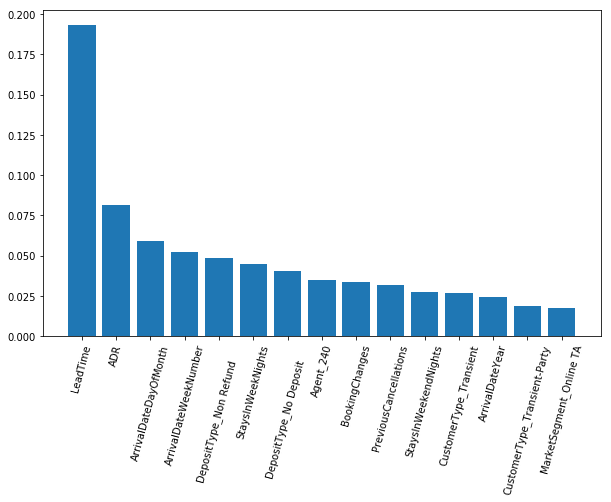

In [40]:
plt.figure(figsize=(10,6))
plt.bar(feature_importances_rf.index, feature_importances_rf['importance'])
plt.xticks(feature_importances_rf.index, rotation=75)

Use confusion matrix to visualise results:

In [41]:
pred_rf = model_rf.predict(X_test)
cm_rf = confusion_matrix(y_test, pred_rf)
cm_rf

array([[1227,  232],
       [ 155,  386]])

Plot confusion matrix:

[Text(0, 0.5, 'Not Canceled'), Text(0, 1.5, 'Canceled')]

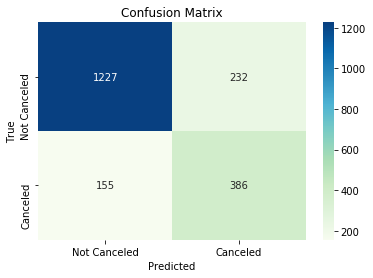

In [42]:
ax= plt.subplot()
cmap = plt.get_cmap('GnBu')
#cmap = plt.get_cmap('BuGn') ('summer') ('Dark2') ('Set2') ('Set3')

sns.heatmap(cm_rf, annot=True, ax = ax, fmt='d', cmap=cmap)

ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Not Canceled', 'Canceled'])
ax.yaxis.set_ticklabels(['Not Canceled', 'Canceled'])

Draw area under curve:

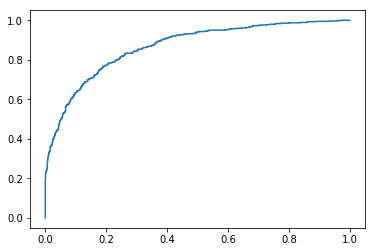

In [43]:
y_pred_proba_rf = model_rf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_rf)
auc = metrics.roc_auc_score(y_test, y_pred_proba_rf)
plt.plot(fpr,tpr)

### Fine tune hyper-parameters on best model:  XG Boost

Initate model:

In [44]:
xgb = XGBClassifier()

Define parameter list:

In [45]:
param_grid_xgb = {'max_depth': [5, 10, 15],
              'n_estimators': [5, 10, 50, 100],
                 'max_features': [5, 7, 10],
                 'scale_pos_weight': [2.59]}
                
# n_estimators = number of trees in random forest
# max_depth = maximum number of levels in tree

Pass the initated model, hyper-parameter dictionary and cross validation to the GridSearchCV:

In [46]:
grid_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, scoring='accuracy')

Fit this grid to the train dataset:

In [47]:
grid_xgb.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [5, 10, 15], 'max_features': [5, 7, 10],
                         'n_estimators': [5, 10, 50, 100],
                         'scale_pos_wei

Print score for best performing hyper-parameters & best hyper-parameters:

In [48]:
print(grid_xgb.best_score_)
print(grid_xgb.best_params_)

0.793875
{'max_depth': 15, 'max_features': 5, 'n_estimators': 100, 'scale_pos_weight': 2.59}


Save this best scoring estimator as a model:

In [49]:
model_xgb=grid_xgb.best_estimator_

Test this model to test dataset (final evaluation):

In [50]:
model_xgb.score(X_test, y_test)

0.809

In [51]:
pred_xgb = model_xgb.predict(X_test)
metrics.precision_score(y_test, pred_xgb)

0.6387434554973822

Feature importances:

In [52]:
feature_importances_xgb = pd.DataFrame(model_xgb.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances_xgb = feature_importances_xgb.head(15)
feature_importances_xgb

,importance
DepositType_Non Refund,0.247600
Agent_240,0.087426
PreviousCancellations,0.035595
Agent_242,0.029387
CustomerType_Transient,0.026610
Company_ 110,0.022345
IsRepeatedGuest,0.017695
PreviousBookingsNotCanceled,0.016812
MarketSegment_Offline TA/TO,0.016427
Company_ 135,0.015391


([<matplotlib.axis.XTick at 0x1a20a69f28>,
 <a list of 15 Text xticklabel objects>)

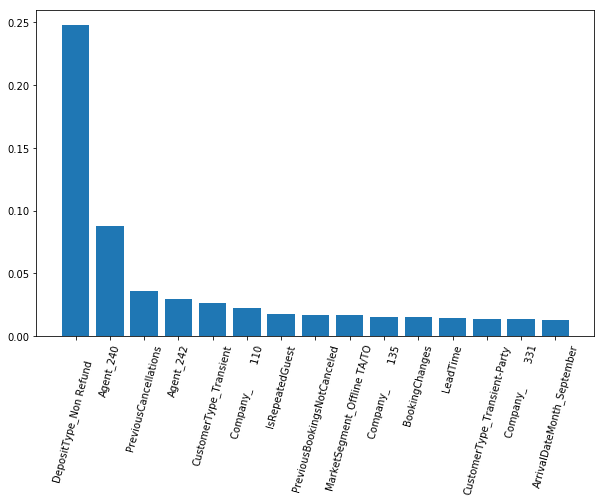

In [53]:
plt.figure(figsize=(10,6))

plt.bar(feature_importances_xgb.index, feature_importances_xgb['importance'])
plt.xticks(feature_importances_xgb.index, rotation=75)

Use confusion matrix to visualise results:

In [54]:
pred_xgb = model_xgb.predict(X_test)
cm_xgb = confusion_matrix(y_test, pred_xgb)
cm_xgb

array([[1252,  207],
       [ 175,  366]])

Plot confusion matrix:

[Text(0, 0.5, 'Not Canceled'), Text(0, 1.5, 'Canceled')]

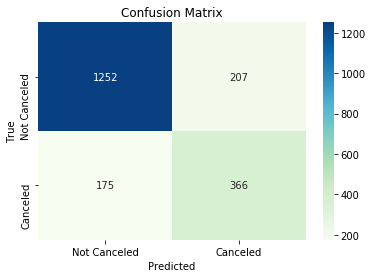

In [55]:
ax= plt.subplot()
cmap = plt.get_cmap('GnBu')
sns.heatmap(cm_xgb, annot=True, ax = ax, fmt='d', cmap=cmap)

ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Not Canceled', 'Canceled'])
ax.yaxis.set_ticklabels(['Not Canceled', 'Canceled'])

Draw area under curve:

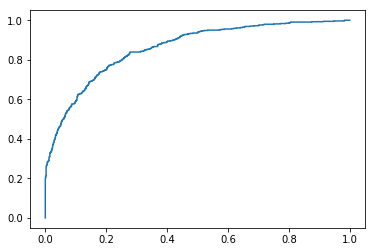

In [56]:
y_pred_proba_xgb = model_xgb.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_xgb)
auc = metrics.roc_auc_score(y_test, y_pred_proba_xgb)
plt.plot(fpr,tpr)

### Fine tune hyper-parameters on best model:  Gradient Boosting Classifier

Initate model:

In [57]:
gbclass = GradientBoostingClassifier()

Define parameter list:

In [58]:
param_grid_gb = {'max_depth': [5, 10, 15],
              'max_features': [5, 7, 10],
              'n_estimators': [5, 10, 50, 100]}
               
# n_estimators = number of trees in random forest
# max_depth = maximum number of levels in tree

Pass the initated model, hyper-parameter dictionary and cross validation to the GridSearchCV:

In [59]:
grid_gb = GridSearchCV(gbclass, param_grid_gb, cv=5, scoring='accuracy')

Fit this grid to the train dataset:

In [60]:
grid_gb.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
         

Print score for best performing hyper-parameters & best hyper-parameters:

In [61]:
print(grid_gb.best_score_)
print(grid_gb.best_params_)

0.8126249999999999
{'max_depth': 10, 'max_features': 7, 'n_estimators': 50}


Save this best scoring estimator as a model:

In [62]:
model_gb=grid_gb.best_estimator_

Test this model to test dataset (final evaluation):

In [63]:
model_gb.score(X_test, y_test)

0.822

In [64]:
pred_gb = model_gb.predict(X_test)
metrics.precision_score(y_test, pred_gb)

0.7329974811083123

Feature importances:

In [65]:
feature_importances_gb = pd.DataFrame(model_gb.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances_gb = feature_importances_gb.head(15)
feature_importances_gb

,importance
LeadTime,0.184513
ADR,0.076288
DepositType_Non Refund,0.072667
DepositType_No Deposit,0.058624
ArrivalDateDayOfMonth,0.047461
PreviousCancellations,0.046367
ArrivalDateWeekNumber,0.045916
StaysInWeekNights,0.041485
Agent_240,0.037215
BookingChanges,0.032699


([<matplotlib.axis.XTick at 0x1a2581b2b0>,
 <a list of 15 Text xticklabel objects>)

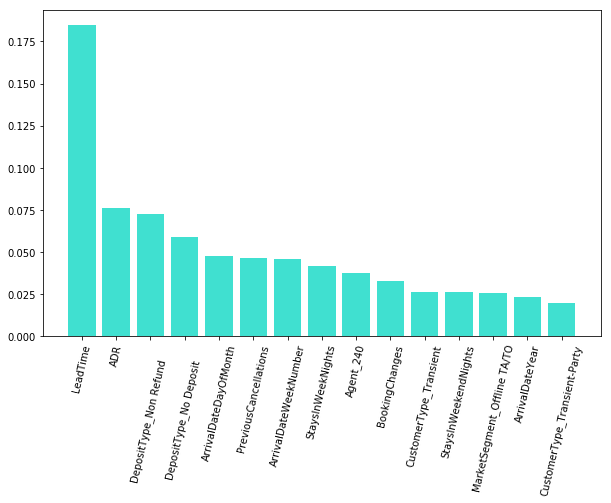

In [95]:
plt.figure(figsize=(10,6))

plt.bar(feature_importances_gb.index, feature_importances_gb['importance'], color='turquoise')
plt.xticks(feature_importances_gb.index, rotation=77)

Use confusion matrix to visualise results:

In [67]:
pred_gb = model_gb.predict(X_test)
cm_gb = confusion_matrix(y_test, pred_gb)
cm_gb

array([[1353,  106],
       [ 250,  291]])

Plot confusion matrix:

[Text(0, 0.5, 'Not Canceled'), Text(0, 1.5, 'Canceled')]

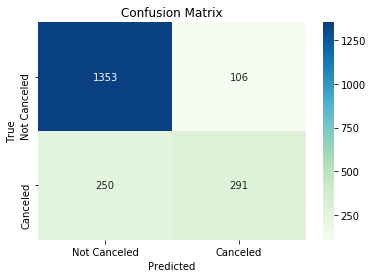

In [68]:
ax= plt.subplot()
cmap = plt.get_cmap('GnBu')
sns.heatmap(cm_gb, annot=True, ax = ax, fmt='d', cmap=cmap)

ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Not Canceled', 'Canceled'])
ax.yaxis.set_ticklabels(['Not Canceled', 'Canceled'])

Draw area under curve:

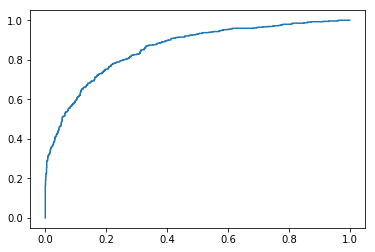

In [69]:
y_pred_proba_gb = model_gb.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_gb)
auc = metrics.roc_auc_score(y_test, y_pred_proba_gb)
plt.plot(fpr,tpr)

View probability of each predicted class

In [139]:
cxl_proba_gb = model_gb.predict_proba(X_test)
cxl_proba_gb

array([[0.77930165, 0.22069835],
       [0.93865485, 0.06134515],
       [0.90160035, 0.09839965],
       ...,
       [0.7619471 , 0.2380529 ],
       [0.89240054, 0.10759946],
       [0.55782745, 0.44217255]])

In [140]:
# show the inputs and predicted probabilities
pred_gb= model_gb.predict(X_test)
probabilities_gb = []

for i in range(len(y_test)):
    #print("Probability=%s, Predicted=%s" % (cxl_proba_gb[i], pred_gb[i]))
    probabilities_gb.append([cxl_proba_gb[i][0], cxl_proba_gb[i][1], pred_gb[i]])

In [148]:
df_probabilities_gb = pd.DataFrame(probabilities_gb, columns= ['Probability_0', 'Probability_1', 'Predicted'])

In [154]:
df_probabilities_gb[(df_probabilities_gb.Predicted == 1)].shape[0]

397

In [159]:
df_probabilities_gb[(df_probabilities_gb.Predicted == 1) & (df_probabilities_gb.Probability_1>0.75)].shape[0]

134

In [160]:
134/2000

0.067

### Result Analysis

#### Create result df with X_test and actual vs predicted values of y

In [100]:
pred_gb = model_gb.predict(X_test)

In [101]:
df_pred_gb  = pd.DataFrame(pred_gb)

In [102]:
df_result = X_test.reset_index()
df_result["Actual"] = y_test.reset_index()["IsCanceled"]
df_result["Prediction"] = df_pred_gb.reset_index()[0]

In [103]:
df_result.head()

,index,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,BookingChanges,DaysInWaitingList,ADR,ArrivalDateMonth_April,ArrivalDateMonth_August,ArrivalDateMonth_December,ArrivalDateMonth_February,ArrivalDateMonth_January,ArrivalDateMonth_July,ArrivalDateMonth_June,ArrivalDateMonth_March,ArrivalDateMonth_May,ArrivalDateMonth_November,ArrivalDateMonth_October,ArrivalDateMonth_September,MarketSegment_Complementary,MarketSegment_Corporate,MarketSegment_Direct,MarketSegment_Groups,MarketSegment_Offline TA/TO,MarketSegment_Online TA,DistributionChannel_Corporate,DistributionChannel_Direct,DistributionChannel_TA/TO,ReservedRoomType_A,ReservedRoomType_C,ReservedRoomType_D,ReservedRoomType_E,ReservedRoomType_F,ReservedRoomType_G,ReservedRoomType_H,DepositType_No Deposit,DepositType_Non Refund,DepositType_Refundable,Agent_240,Agent_241,Agent_242,Agent_243,Agent_250,Agent_298,Agent_314,Agent_40,Agent_6,Agent_Not applicable,Agent_Other,CustomerType_Contract,CustomerType_Group,CustomerType_Transient,CustomerType_Transient-Party,Company_ 94,Company_ 110,Company_ 135,Company_ 154,Company_ 204,Company_ 223,Company_ 281,Company_ 331,Company_ 405,Company_ Not applicable,Company_Other,Actual,Prediction
0,36439,131,2017,21,23,2,5,2,0.0,0,0,0,0,1,0,131.63,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,33674,14,2017,10,8,0,3,2,0.0,0,0,0,0,0,0,60.00,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
2,37814,5,2017,27,8,2,1,2,2.0,0,0,0,0,0,0,260.00,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,10396,86,2017,10,9,0,3,2,0.0,0,0,0,0,0,0,46.00,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1
4,32952,73,2017,7,17,1,2,2,0.0,0,0,0,0,0,0,40.00,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1


In [104]:
df_result.Actual.value_counts()

0    1459
1     541
Name: Actual, dtype: int64

In [105]:
df_result.Prediction.value_counts()

0    1603
1     397
Name: Prediction, dtype: int64

#### Create 2 data frames with original Train (X+y) & Test (X+y) datasets (to compare feature distribution per class with predicted results)

In [106]:
df1 = pd.concat([X_test,y_test],axis=1)

In [107]:
df2 = pd.concat([X_train,y_train],axis=1)